# EfficientNet-v2-s


## Importamos librerias

In [1]:
import time
import copy
import numpy as np
import pandas as pd
from typing import Tuple, Dict, List
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms

from torchinfo import summary

Definimos varios parámetros que vamos a utilizar a lo largo del cuaderno, por ejemplo el diccionario que vamos a utilizar para alamacenar los valores de precisión y perdida que se van generando durante el entrenamiento. La resolución de a la que vamos a ajutar las imágenes. El directorio donde se almacenan los datos. Etc.

In [2]:
# Creamos un diccionario vacio para almacenar los resultados
results = {'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
cudnn.benchmark = True

data_dir = './data'
img_size = (224, 224)
bs = 16
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
num_epochs = 25
output_classes = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Definimos el parámetro transform

Definimos las diferentes transformaciones que se van a aplicar previamente sobre los datos:

* Redimensionamos todas las imágenes al mismo tamaño (224x224).
* Aleatoriamente se aplica un giro horizontal de la imagen.
* Rotamos la imagen 10 grados de forma aleatoria.
* Los trasformaremos en tensores y normalizamos $\frac{x-mean}{std}$ centrado en 0 y [-1, 1].

Inicialmente, vamos a aplicar la misma transformación al conjunto de datos de entrenamiento que al conjunto de datos de validación. Pero hemos escrito el código de forma que se puedan aplicar diferentes transformaciones al conjunto de datos de entrenamiento que al conjunto de datos de validación.

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

## Carga de datos

Hemos decidido utilizar el conjunto de datos del iNat Challenge 2.021 para entrenar y validar nuestro modelo. Contiene imágenes de 10.000 especies diferentes. El conjunto de datos de entrenamiento mini formado por 500.000 imágenes, que contiene 50 imágenes de cada una de las especies catalogadas. El conjunto de datos de validación contiene para cada especie 10 imágenes, sumando un total de 100.000 imágenes.

80% de los datos forman parte del conjunto de datos de entrenamiento y el 20% de los datos son el conjunto de validación.

In [4]:
image_datasets = {
    x: datasets.INaturalist(
        root = data_dir,
        version = '2021_train_mini' if x == 'train' else '2021_valid',
        transform = data_transforms[x],
        download = False
    )
    for x in ['train', 'val']
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size = bs,
        shuffle = True,
        num_workers = 4
    )
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
inputs, classes = next(iter(dataloaders['train']))
print(f'Conjuntos de entrenamiento: {dataset_sizes} clases: {output_classes}')

Conjuntos de entrenamiento: {'train': 500000, 'val': 100000} clases: 10000


## Función de entrenamiento

Definimos la función que nos servirá para entrenar nuestra red neuronal. Esta función devuelve como resultado el modelo con los parámetros ajustados a la ejecucion del entrenamiento en el que obtivo un mayor porcentaje de acierto en la validación del modelo. 

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Entrenando etapa {epoch + 1} de {num_epochs} ...')
        epoch_init = time.time()

        # Cada iteración tiene una fase de validación y una fase de entrenamiento
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Establece el modelo en modo entrenamiento
            else:
                model.eval()   # Establece el modelo en modo validación

            running_loss = 0.0
            running_corrects = 0

            # Itera sobre los datos
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # pone a cero los gradientes de los tensores optimizados
                optimizer.zero_grad()

                # track historial adelante solo en la fase de entrenamiento
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Solo si está en la fase de entrenamiento retroceder + optimizar
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # estatisticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                results["train_loss"].append(epoch_loss)
                results["train_acc"].append(epoch_acc.item())
                print(f'Entrenamiento\tPerdida: {epoch_loss:.4f}\tPrecisión: {epoch_acc:.4f}')
            else:
                tittle = 'Validación'
                results["val_loss"].append(epoch_loss)
                results["val_acc"].append(epoch_acc.item())
                print(f'Validación\tPerdida: {epoch_loss:.4f}\tPrecisión: {epoch_acc:.4f}'
                      f'\t{(time.time() - epoch_init)//60:.0f}min {(time.time() - epoch_init)%60:.0f}seg')
            
            # copia del modelo con mejor porcentaje de acierto en la validación
            if phase == 'val' and epoch_acc > best_acc:
                print('Guardando el modelo ...')
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    if time_elapsed < 3600:
        print(f'Entrenamiento completado en: {time_elapsed // 60:.0f}min. {time_elapsed % 60:.0f}seg.')
    else:
        rest_elapsed = time_elapsed % 3600
        print(f'Entrenamiento completado en: {time_elapsed // 3600:.0f}horas {rest_elapsed // 60:.0f}min. {rest_elapsed % 60:.0f}seg.')
    print(f'Mejor precisión validación: {best_acc:4f}')

    # guarda los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    return model

## Cargando el modelo sin inicializar

El modelo lo cargamos sin los pesos de preentrenamiento de ImageNet

In [6]:
model = models.efficientnet_v2_s(weights=None)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

## Modificamos el clasificador

Adaptamos la última capa para que la salida coincida con el número de clases que tenemos a clasificar

In [7]:
num_ftrs = model.classifier[1].in_features

classifier = nn.Sequential(OrderedDict([
    ('0', nn.Dropout(p=0.4, inplace=True)),
    ('1', nn.Linear(num_ftrs, output_classes))
]))

In [8]:
classifier

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1280, out_features=10000, bias=True)
)

In [9]:
model.classifier = classifier

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Se optimizan todos los parámetros
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Se decrementa LR por un factor 0.1 cada 7 iteraciones
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
summary(model)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 648
│    │    └─BatchNorm2d: 3-2                            48
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─FusedMBConv: 3-4                            5,232
│    │    └─FusedMBConv: 3-5                            5,232
│    └─Sequential: 2-3                                  --
│    │    └─FusedMBConv: 3-6                            25,632
│    │    └─FusedMBConv: 3-7                            92,640
│    │    └─FusedMBConv: 3-8                            92,640
│    │    └─FusedMBConv: 3-9                            92,640
│    └─Sequential: 2-4                                  --
│    │    └─FusedMBConv: 3-1

## Entrenamos el modelo

In [11]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs)

Entrenando etapa 1 de 25 ...
Entrenamiento	Perdida: 9.0436	Precisión: 0.0002
Validación	Perdida: 8.7871	Precisión: 0.0006	72min 38seg
Guardando el modelo ...

Entrenando etapa 2 de 25 ...
Entrenamiento	Perdida: 8.5349	Precisión: 0.0010
Validación	Perdida: 8.0549	Precisión: 0.0023	73min 10seg
Guardando el modelo ...

Entrenando etapa 3 de 25 ...
Entrenamiento	Perdida: 7.9771	Precisión: 0.0032
Validación	Perdida: 7.4780	Precisión: 0.0082	76min 30seg
Guardando el modelo ...

Entrenando etapa 4 de 25 ...
Entrenamiento	Perdida: 7.4736	Precisión: 0.0077
Validación	Perdida: 6.9315	Precisión: 0.0177	72min 44seg
Guardando el modelo ...

Entrenando etapa 5 de 25 ...
Entrenamiento	Perdida: 7.0157	Precisión: 0.0157
Validación	Perdida: 6.4726	Precisión: 0.0316	68min 50seg
Guardando el modelo ...

Entrenando etapa 6 de 25 ...
Entrenamiento	Perdida: 6.6021	Precisión: 0.0268
Validación	Perdida: 6.0611	Precisión: 0.0511	68min 9seg
Guardando el modelo ...

Entrenando etapa 7 de 25 ...
Entrenamiento	Perd

## Exportamos los resultados a un CSV

Exportamos los resultados del entrenamiento a un fichero csv, separado por tabuladores

In [13]:
df_results = pd.DataFrame(results)
df_results.to_csv('EfficientNetV2s_results.txt', sep='\t', index=False)

## Gráfica pérdida y precisión

In [14]:
import matplotlib.pyplot as plt
def plot_curves(results: Dict[str, List[float]]):
    
    # Recuperamos los valores de pérdida de entrenamiento y validación
    loss = results['train_loss']
    test_loss = results['val_loss']

    # Recuperamos los valores de precisión de entrenamiento y validación
    accuracy = results['train_acc']
    test_accuracy = results['val_acc']

    # Número de iteraciones que tenemos
    epochs = range(len(results['train_loss']))

    # Definimos el gráfico
    plt.figure(figsize=(15, 7))

    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Pérdida entrenamiento')
    plt.plot(epochs, test_loss, label='Pérdida validacion')
    plt.ylabel('Pérdida')
    plt.xlabel('Iteraciones')
    plt.legend()

    # Precisión
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Precisión entrenamiento')
    plt.plot(epochs, test_accuracy, label='Precisión validación')
    plt.ylabel('Precisión')
    plt.xlabel('Iteraciones')
    plt.legend();

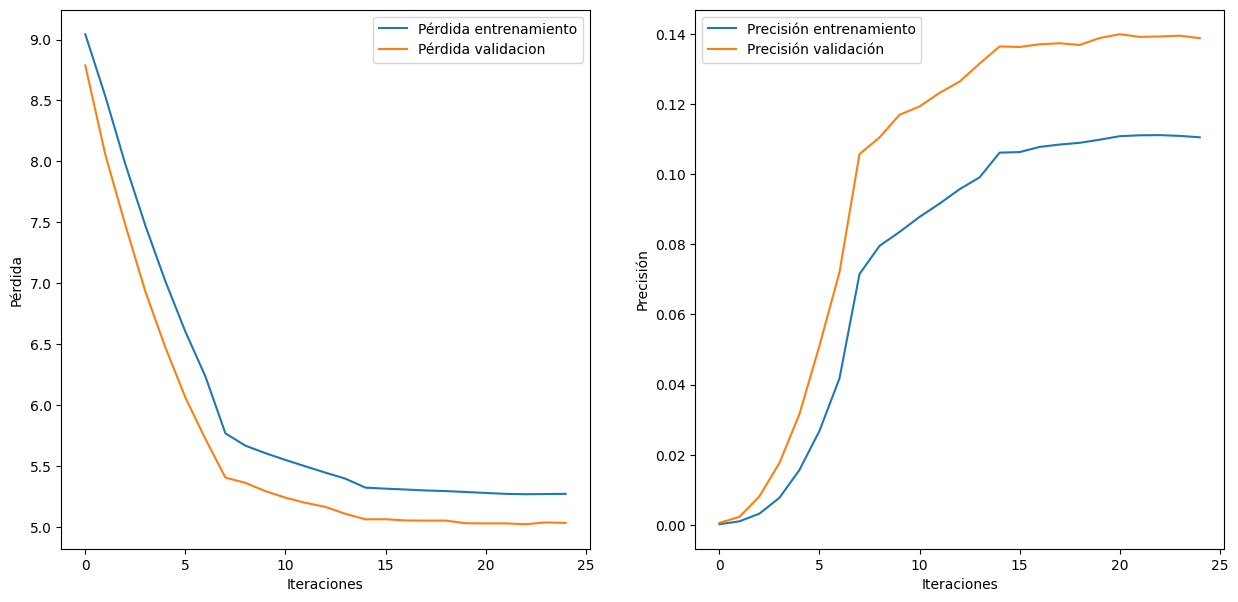

In [16]:
plot_curves(results)